In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [23]:
pip install hdbscan

In [22]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.0 MB/s eta 0:00:00


In [2]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.4MB/s]
100%|██████████| 58/58 [00:34<00:00,  1.69it/s]


In [3]:
# Load VGG model
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

# Print VGG network architecture
print(vgg)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

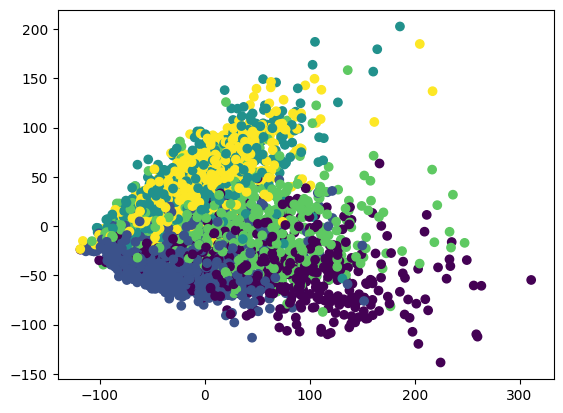

In [4]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

In [5]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


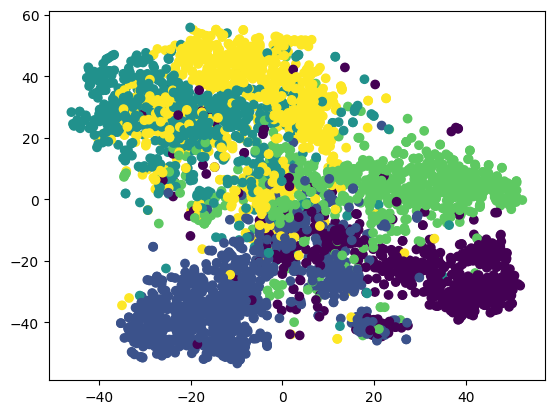

In [6]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components = 2, random_state = 42).fit_transform(f_all)
plt.scatter(*tsne.T, c = y_all)

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                optimizer.zero_grad()
                outputs = self.model(X_)

                loss = criterion(outputs, y_)
                loss.backward()

                optimizer.step()
                ##################################
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        X = torch.tensor(X_test, dtype=torch.float32, device = 'cuda')
        y = torch.tensor(y_test, dtype=torch.int64, device = 'cuda')

        criterion = nn.NLLLoss()
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size = 100)

        total = 0
        correct = 0

        with torch.no_grad():
            for X, y in dataloader:
                output = self.model(X)
                _, pred = torch.max(output, 1)
                total += y.size(0)
                correct += (pred == y).sum().item()

        accuracy = (correct / total) * 100

        return accuracy

        ##################################

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size = 0.2)

mlp = MLP(f_all.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


90.46321525885558

In [16]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


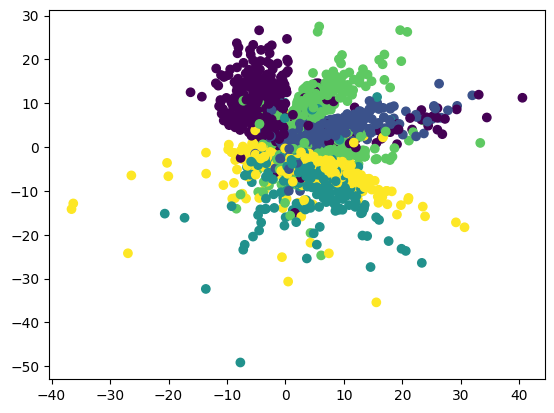

In [17]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [18]:
# Reduced Dimensionality using Autoencoder
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_em, y_all, test_size = 0.2)

mlp = MLP(X_em.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


77.79291553133515

In [50]:
# Reduced Dimensionality using UMAP

umap = UMAP(n_components = 50, random_state = 0, metric = 'cosine').fit_transform(f_all)

X_train, X_test, y_train, y_test = train_test_split(umap, y_all, test_size = 0.2)

mlp = MLP(umap.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


82.9700272479564

In [51]:
# Reduced Dimensionality using SVD

svd = TruncatedSVD(n_components = 50, random_state = 0).fit_transform(f_all)

X_train, X_test, y_train, y_test = train_test_split(svd, y_all, test_size = 0.2)

mlp = MLP(svd.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


89.91825613079018

In [27]:
# K-Means (No Dimensionality Reduction)
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters = 5).fit(f_all)

rand_score_kmeans = adjusted_rand_score(y_all, kmeans.labels_)

# Print the Rand score
print("Rand score for K-Means: ", rand_score_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Rand score for K-Means: 0.19297767800780355


In [28]:
# Agglomerative Clustering (No Dimesionality Reduction)
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=5).fit_predict(f_all)

rand_score_agg = adjusted_rand_score(y_all, agg_clustering)

# Print the Rand score
print("Rand score for Agglomerative Clustering: ", rand_score_agg)

Rand score for Agglomerative Clustering: 0.2184499487113686


In [29]:
# HDBSCAN (No Dimensionality Reduction)
import hdbscan

hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples = 5).fit_predict(f_all)

rand_score_hdbscan = adjusted_rand_score(y_all, hdbscan_clustering)

# Print the Rand score
print("Rand score for HDBSCAN Clustering: ", rand_score_hdbscan)


Rand score for HDBSCAN Clustering: 0.006675668759554497


In [38]:
# K-Means (w/ SVD)
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 50, random_state = 0).fit_transform(f_all)

kmeans = KMeans(n_clusters = 5, random_state = 0).fit(svd)

rand_score_kmeans_svd = adjusted_rand_score(y_all, kmeans.labels_)

print("K-means & SVD Rand Score: ", rand_score_kmeans_svd)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means & SVD Rand Score:  0.19044865806120873


In [36]:
# Agglomerative Clustering (w/ SVD)

svd = TruncatedSVD(n_components = 50, random_state = 0).fit_transform(f_all)

agg_clustering = AgglomerativeClustering(n_clusters=5).fit_predict(svd)

rand_score_agg_svd = adjusted_rand_score(y_all, agg_clustering)

# Print the Rand score
print("Rand score for Agglomerative Clustering with SVD: ", rand_score_agg_svd)

Rand score for Agglomerative Clustering with SVD: 0.2022483886951178


In [37]:
# HDBSCAN (w/ SVD)

svd = TruncatedSVD(n_components = 50, random_state = 0).fit_transform(f_all)

hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples = 5).fit_predict(svd)

rand_score_hdbscan_svd = adjusted_rand_score(y_all, hdbscan_clustering)

# Print the Rand score
print("Rand score for HDBSCAN Clustering: ", rand_score_hdbscan_svd)

Rand score for HDBSCAN Clustering:  0.005930192366726087


In [43]:
# K-Means (w/ UMAP)
from umap import UMAP

umap = UMAP(n_components = 50, random_state = 0, metric = 'cosine').fit_transform(f_all)

kmeans = KMeans(n_clusters = 5, random_state = 0).fit(umap)

rand_score_kmeans_umap = adjusted_rand_score(y_all, kmeans.labels_)

print("K-means & UMAP Rand Score: ", rand_score_kmeans_umap)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


K-means & SVD Rand Score:  0.4640108350485489


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
# Agglomerative Clustering (w/ UMAP)

umap = UMAP(n_components = 50, random_state = 0, metric = 'cosine').fit_transform(f_all)

agg_clustering = AgglomerativeClustering(n_clusters=5).fit_predict(umap)

rand_score_agg_umap = adjusted_rand_score(y_all, agg_clustering)

# Print the Rand score
print("Rand score for Agglomerative Clustering with UMAP: ", rand_score_agg_umap)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Rand score for Agglomerative Clustering with SVD:  0.48395928174654673


In [45]:
# HDBSCAN (w/ UMAP)

umap = UMAP(n_components = 50, random_state = 0, metric = 'cosine').fit_transform(f_all)

hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples = 5).fit_predict(umap)

rand_score_hdbscan_umap = adjusted_rand_score(y_all, hdbscan_clustering)

# Print the Rand score
print("Rand score for HDBSCAN Clustering: ", rand_score_hdbscan_umap)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Rand score for HDBSCAN Clustering:  0.0945246169287157


In [46]:
# K-Means (w/ Autoencoder)

autoencoder = Autoencoder(50).fit_transform(f_all)

kmeans = KMeans(n_clusters = 5, random_state = 0).fit(autoencoder)

rand_score_kmeans_auto = adjusted_rand_score(y_all, kmeans.labels_)

print("K-means & SVD Rand Score: ", rand_score_kmeans_auto)

100%|██████████| 100/100 [00:22<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means & SVD Rand Score:  0.22961543131456136


In [48]:
# Agglomerative Clustering (w/ Autoencoder)

autoencoder = Autoencoder(50).fit_transform(f_all)

agg_clustering = AgglomerativeClustering(n_clusters=5).fit_predict(autoencoder)

rand_score_agg_auto = adjusted_rand_score(y_all, agg_clustering)

# Print the Rand score
print("Rand score for Agglomerative Clustering with SVD: ", rand_score_agg_auto)

100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


Rand score for Agglomerative Clustering with SVD:  0.25003372779010113


In [49]:
# HDBSCAN (w/ Autoencoder)

autoencoder = Autoencoder(50).fit_transform(f_all)

hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size = 5,
                                     min_samples = 5).fit_predict(autoencoder)

rand_score_hdbscan_auto = adjusted_rand_score(y_all, hdbscan_clustering)

# Print the Rand score
print("Rand score for HDBSCAN Clustering: ", rand_score_hdbscan_auto)

100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Rand score for HDBSCAN Clustering:  0.007793750676370485
